In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [3]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'lines.linewidth' : 1.5,
    'lines.markersize' : 10,
    'figure.figsize': (8,5),
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12,
    'font.family': 'serif',
    'legend.fontsize':12,
    'axes.labelsize':18
})

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1875355515388444230
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4177330176
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5466657428323516754
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

# Importing Kuramoto dataset

We first import the solution obtained from the Kuramoto differential equation subject to periodic boundary conditions. The spatial domain has length L=200 and discretized with 256 nodes. The time step was 0.25 s with a time domain from t=0 to t=2000 s.


$$ u_t + u_x u + u_{xx} + u_{xxxx}=0 \tag{1} $$ 


$$ u(t=0,x) = cos \frac{\pi x}{20}*(1+sin\frac{\pi x}{20}) $$

The first 200 seconds were truncated in order to view the more chaotic part of the solution

In [7]:
X = np.load('Kuramoto_dataset/Kuramoto_X.npy')
T = np.load('Kuramoto_dataset/Kuramoto_T.npy')
U = np.load('Kuramoto_dataset/Kuramoto_U.npy')

In [8]:
X.shape

(40001, 256)

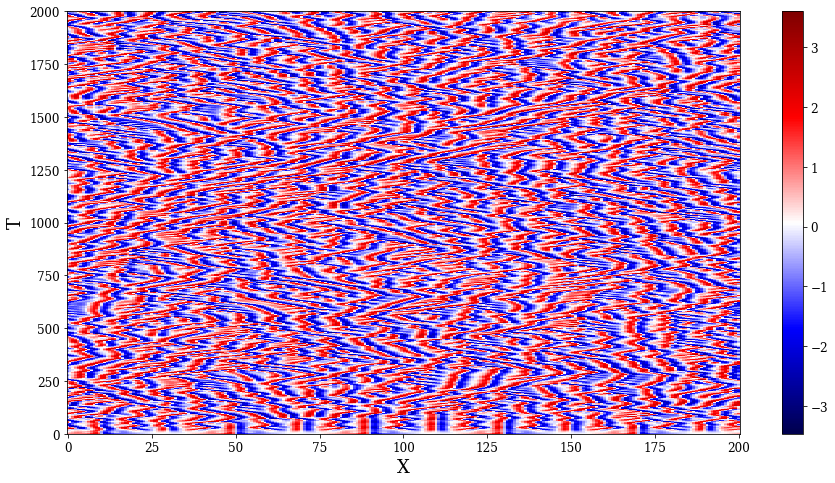

In [9]:
fig, ax = plt.subplots(figsize=(13, 7))

surf = plt.pcolor(X,T,U,cmap='seismic',shading='auto')

fig.colorbar(surf)
plt.xlabel('X')
plt.ylabel('T')
plt.tight_layout()

In [10]:
# Taking out the first 200 seconds of data

X2 = X[4000:]
T2 = T[4000:]
U2 = U[4000:]

In [11]:
# Test dataset to validate model
Xtest=X2[30000:]
Ttest=X2[30000:]
Utest=X2[30000:]

# Training dataset - 90% of data
X2 = X2[4000:30000]
T2 = T2[4000:30000]
U2 = U2[4000:30000]

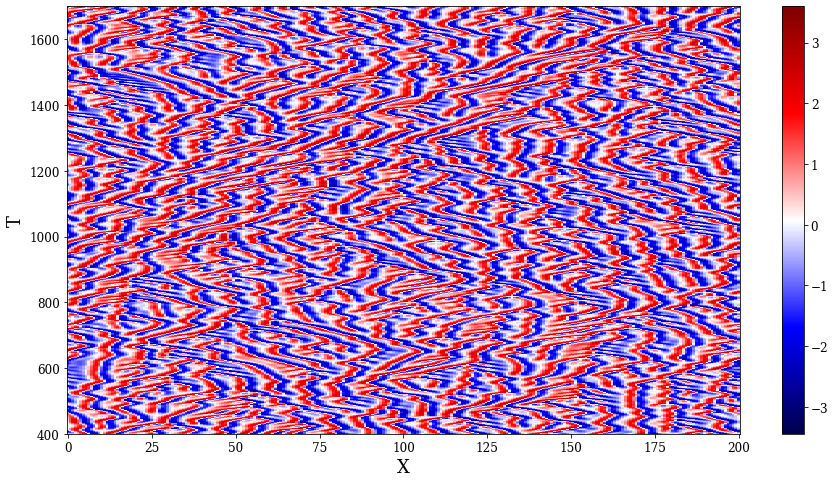

In [12]:
fig, ax = plt.subplots(figsize=(13, 7))

surf = plt.pcolor(X2,T2,U2,cmap='seismic',shading='auto')

fig.colorbar(surf)
plt.xlabel('X')
plt.ylabel('T')
plt.tight_layout()

# PINN - theory

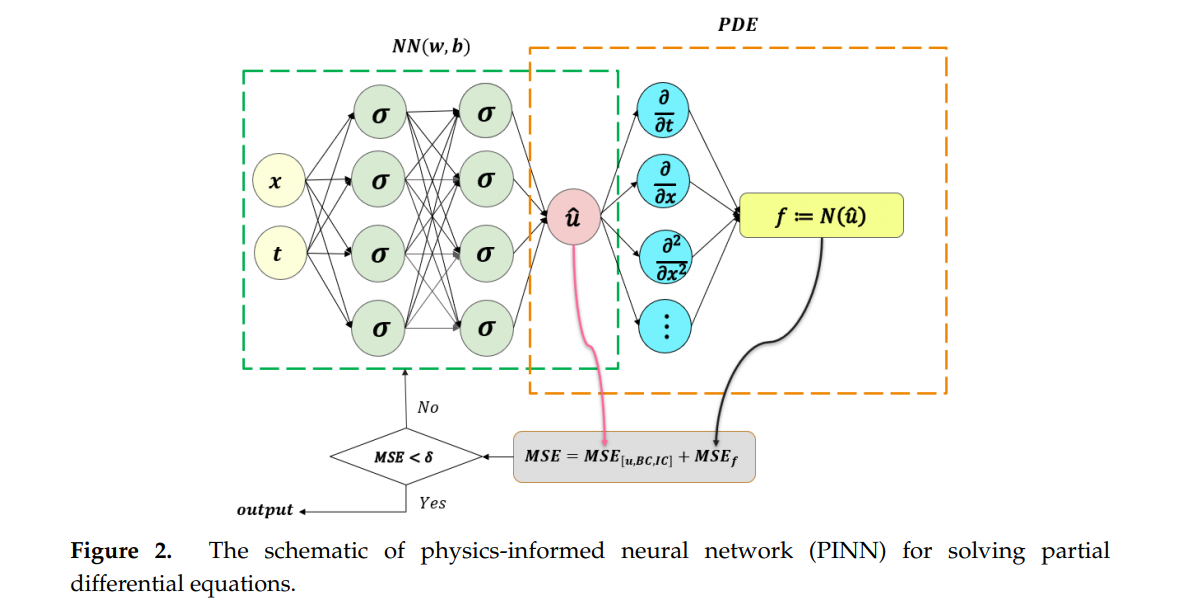

Rewritting the Kuramoto equation:


$$ u_t + u_x u + u_{xx} + u_{xxxx}=0 \tag{3} $$

The neural network will try to find a mapping between the independent variables (**x** and **t** in figure 2) and the approximate solution of the differential equation **u**. This approximation will undergoe automatic differentiation to obtain the expression **f** that is equal to the differential equation we would like to solve. In this case:

$$ f := u_t + u_x u + u_{xx} + u_{xxxx} \tag{4}$$

There will be a neural network MSE (left side) and a differential equation MSE (right side)

The shared parameters between the neural network u(t,x) and residual equation f(t,x) can be learned by minimizing the mean squared error loss below:


$$ MSE = MSE_u + MSE_f \tag{5} $$


Where

- $MSE_u:$ = Error associated with the training data on **u(t,x)** 
- $MSE_f:$ = Error associated by inforcing the structure of equation **f** at a finite set of collocation points, whose number and location is taken from the same training data.

By definition of **f**, $MSE_u$ should be zero, which indicates there is no residual.

# Sampling 

In [13]:
import random
random.seed(123)

def sample_boundaries(X2,T2,U2,Nleft,Nright,Ninit,N_dom):
    
    
    # Collocation points
    rng = np.random.default_rng()
    t_idx=rng.choice(U2.shape[0],N_dom) # size of time domain
    x_idx=rng.choice(U2.shape[1],N_dom) # size of distance domain
    Xdom = X2[[t_idx,x_idx]]
    Tdom = T2[[t_idx,x_idx]]
    Udom = U2[[t_idx,x_idx]]
    

    left_idx=rng.choice(U2.shape[0],Nleft) 
    Xleft = X2[:,0][left_idx]
    Tleft = T2[:,0][left_idx]
    Uleft = U2[:,0][left_idx]

    #print(Xleft)
    #print(Tleft)
    #print(Uleft)

    right_idx=rng.choice(U2.shape[0],Nright) 
    Xright = X2[:,-1][right_idx]
    Tright = T2[:,-1][right_idx]
    Uright = U2[:,-1][right_idx]

    #print(Xright)
    #print(Tright)
    #print(Uright)

    init_idx=rng.choice(U2.shape[1],Ninit) 
    Xinit = X2[0,:][init_idx]
    Tinit = T2[0,:][init_idx]
    Uinit = U2[0,:][init_idx]
    

    
    return Xleft,Tleft,Uleft,Xright,Tright,Uright,Xinit,Tinit,Uinit,Xdom,Tdom,Udom

Xleft,Tleft,Uleft,Xright,Tright,Uright,Xinit,Tinit,Uinit,Xdom,Tdom,Udom = sample_boundaries(X2,T2,U2,Nleft=200,Nright=200,Ninit=128,N_dom=5000)

In [14]:
#plt.scatter(Xleft,Tleft,s=50, color='black', marker='x')
#plt.scatter(Xright,Tright,s=50, color='black', marker='x')
#plt.scatter(Xinit,Tinit,s=50, color='black', marker='x')

#plt.scatter(Xdom,Tdom,s=10, color='red', marker='x',alpha=0.4)

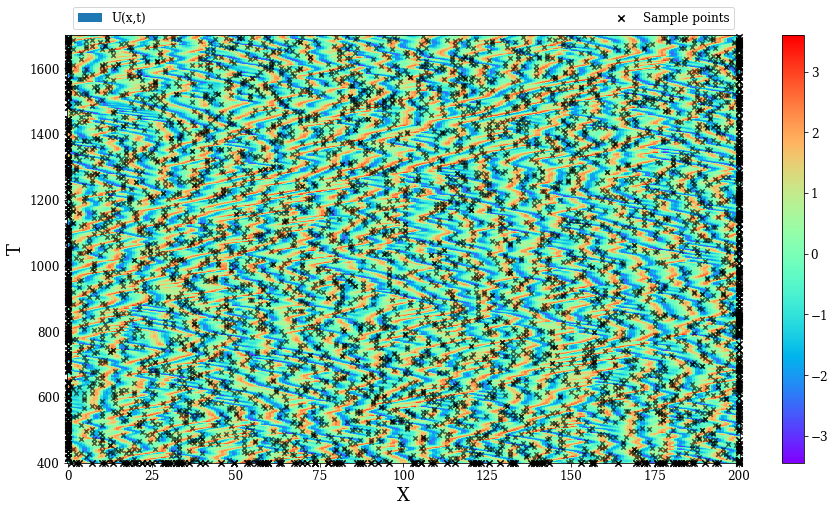

In [15]:
fig, ax = plt.subplots(figsize=(13, 7))

surf = plt.pcolor(X2,T2,U2,cmap='rainbow',shading='auto')
fig.colorbar(surf)

plt.scatter(Xleft,Tleft,s=40, color='black', marker='x',clip_on = False)
plt.scatter(Xright,Tright,s=40, color='black', marker='x',clip_on = False)
plt.scatter(Xinit,Tinit,s=40, color='black', marker='x',clip_on = False)
plt.scatter(Xdom,Tdom,s=20, color='black', marker='x',alpha=0.6)

plt.xlabel('X')
plt.ylabel('T')
plt.tight_layout()
plt.legend(['U(x,t)','Sample points'],bbox_to_anchor=(0, 1, 1, 0), loc="lower right", mode="expand", ncol=2)

# Neural network 

In [16]:
import sciann as sn

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


In [17]:
# Define independent variables
x = sn.Variable("x", dtype='float64')
t = sn.Variable("t", dtype='float64')
u = sn.Field("u",dtype='float64')

In [65]:
# Define the neural network arquitecture to produce the solution U
U = sn.Functional(fields='u',               # output of the neural network
                  variables=[x, t],         # input variables
                  hidden_layers=3*[200],  
                  activation='tanh')      # adaptive activation function ('l-')

# PINN

Writting the equation again:

$$ u_t + u_x u + u_{xx} + u_{xxxx}=0 \tag{1} $$ 

## Defining the Kuramoto equation

In [66]:
# All terms of Kuramoto equation

u_t = sn.diff(U, t)
u_x = sn.diff(U, x)
u_xx = sn.diff(U, x, order=2)
u_xxxx = sn.diff(U, x, order=4)

f = u_t + u_x*U + u_xx + u_xxxx # Kuramoto equation
f = sn.rename(f,'PINN')

## Defining the PINN model

In [68]:
m = sn.SciModel(inputs=[x,t],
                targets=[U,f], # Model must minimize the neural network loss "U" and the PINN loss "f"
                loss_func='mse',
                optimizer='adam',
                #load_weights_from = 'Kuramoto.h5',
                plot_to_file='Kuramoto_network.png')

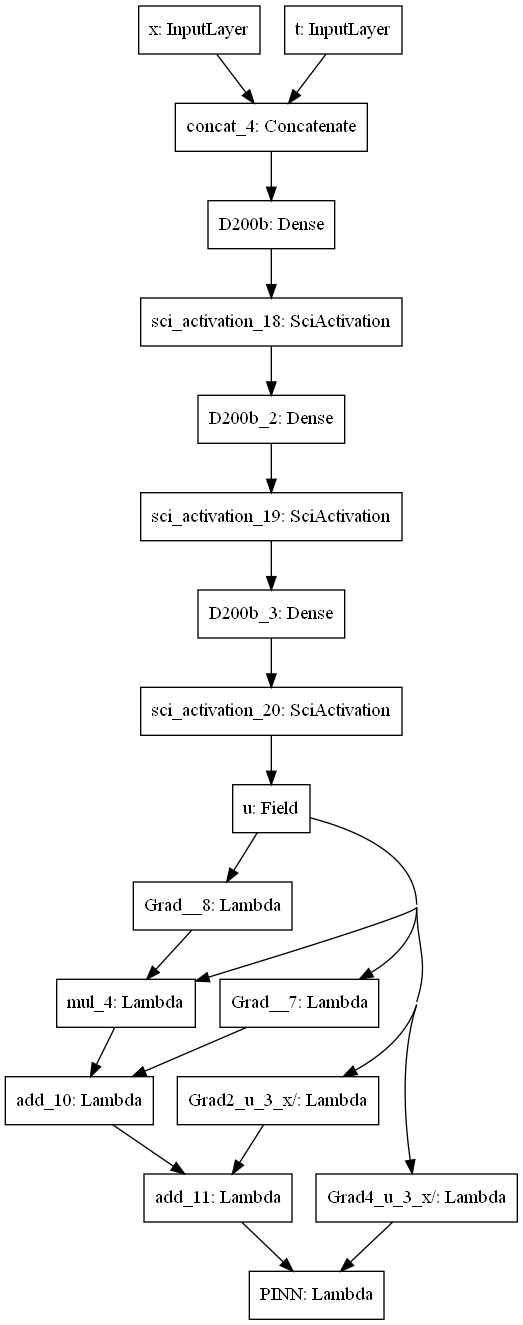

In [69]:
from IPython.display import Image
Image(filename='Kuramoto_network.png')  # Neural network arquitecture

## Creating the dataset

In [70]:
X_train = np.concatenate([Xdom.reshape(-1,1),Xleft.reshape(-1,1),Xright.reshape(-1,1),Xinit.reshape(-1,1)])
T_train = np.concatenate([Tdom.reshape(-1,1),Tleft.reshape(-1,1),Tright.reshape(-1,1),Tinit.reshape(-1,1)])

U_train = np.concatenate([Udom.reshape(-1,1),Uleft.reshape(-1,1),Uright.reshape(-1,1),Uinit.reshape(-1,1)])

In [71]:
ids_dom = np.arange(0,Xdom.size) # index for colocation points
ids_phys = np.arange(ids_dom.size,X_train.size) # index for boundary and initial conditions
ids = np.concatenate([ids_dom,ids_phys])

#ids
#print(ids_dom)
#print('')
#print(ids_phys)

In [73]:
import tensorflow as tf
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

h = m.train([X_train,T_train], # random collocation points inside the domain
            [(ids_dom,U_train[ids_dom]),'zeros'], # the physics equation must be equal to zero while the domain must equal the collocation points
            epochs=500,
            batch_size=64,
            shuffle=True,
            learning_rate=0.005,
            reduce_lr_after=100, #  Reduce learning rate after every 100 epochs
            stop_loss_value = 1e-8,
            save_weights_freq=30,
            callbacks=my_callbacks)


Total samples: 5528 
Batch size: 64 
Total batches: 87 

Epoch 1/500
87/87 [==============================] - 6s 72ms/step - batch: 43.0000 - size: 63.5402 - loss: 1.7513 - u_loss: 1.7510 - PINN_loss: 2.2625e-04
Epoch 5/500
87/87 [==============================] - 6s 73ms/step - batch: 43.0000 - size: 63.5402 - loss: 1.7436 - u_loss: 1.7436 - PINN_loss: 7.5445e-05
Epoch 9/500
87/87 [==============================] - 6s 73ms/step - batch: 43.0000 - size: 63.5402 - loss: 1.7468 - u_loss: 1.7467 - PINN_loss: 4.0407e-05
Epoch 10/500
87/87 [==============================] - 6s 73ms/step - batch: 43.0000 - size: 63.5402 - loss: 1.7420 - u_loss: 1.7420 - PINN_loss: 4.8563e-05
Epoch 12/500
87/87 [==============================] - 6s 73ms/step - batch: 43.0000 - size: 63.5402 - loss: 1.7377 - u_loss: 1.7376 - PINN_loss: 6.8876e-05
Epoch 16/500
87/87 [==============================] - 6s 73ms/step - batch: 43.0000 - size: 63.5402 - loss: 1.7477 - u_loss: 1.7477 - PINN_loss: 4.0672e-05
Epoch 18/

KeyboardInterrupt: 

In [58]:
m.save_weights('Kuramoto.h5')

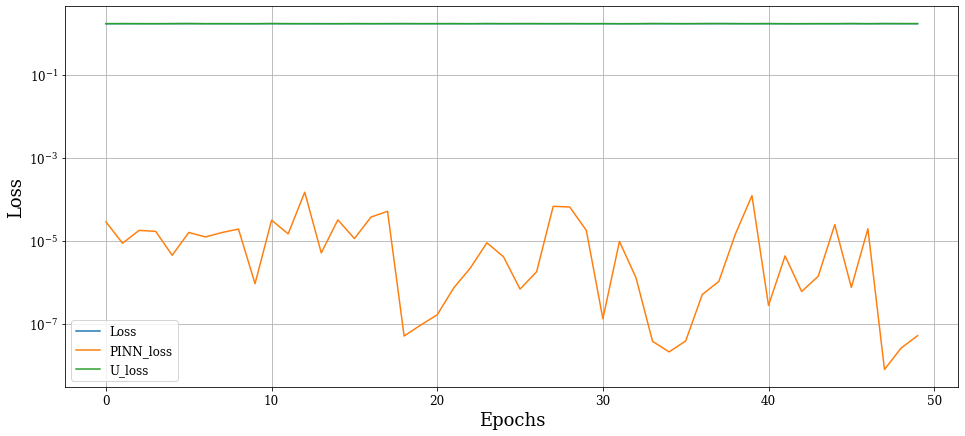

In [60]:
plt.figure(figsize=(16,7))

plt.semilogy(h.history['loss'],label='Loss')
plt.semilogy(h.history['PINN_loss'],label='PINN_loss')
plt.semilogy(h.history['u_loss'],label='U_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [63]:
U_pred = f.eval(m,[X_train, T_train])
U_pred
print(U_pred.shape)

(5528, 1)


In [64]:
U_pred.max()

0.007883257093957593

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[6656000,100] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node D100b_10_1/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[add_9_1/add/_6735]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[6656000,100] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node D100b_10_1/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

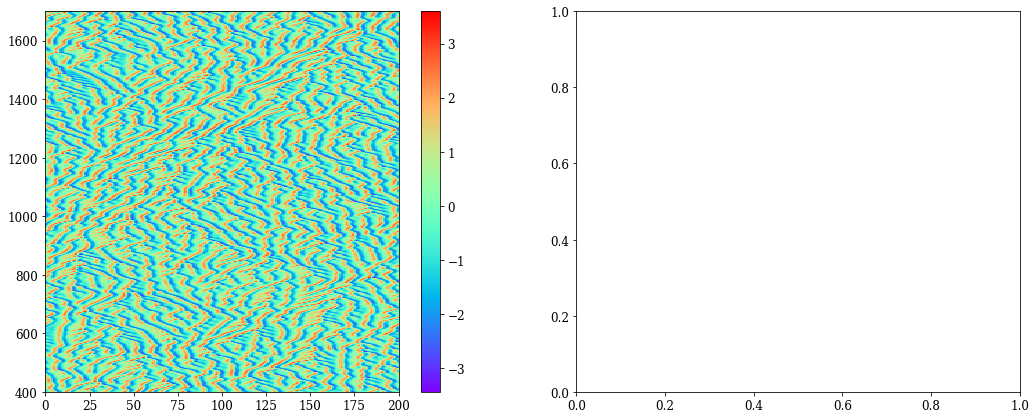

In [61]:
plt.figure(figsize=(27,7))

plt.subplot(1,3,1)
im=plt.pcolor(X2,T2,U2,cmap='rainbow',shading='auto')
plt.colorbar(im)

plt.subplot(1,3,2)
U_pred = f.eval(m,[X2, T2])
plt.pcolor(X2,T2,U_pred,cmap='rainbow',shading='auto')
plt.colorbar()


#plt.subplot(1,3,3)
#diff = abs(U_pred-U)
#plt.pcolor(X,T,diff,cmap='rainbow',shading='auto') # absolute error
#plt.colorbar()

In [ ]:
U_pred[0]

In [ ]:
U_pred = f.eval(m,[X_train, T_train])

In [ ]:
U_pred

In [ ]:
T_train.min()